Project : Image Classification

Things to submit:
1. PPT
2. Video

**LIBRARY & DATASET**

In [ ]:
# Install the required packages if you do not have
# pip install seaborn
# pip install scikit-learn

In [2]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

MNIST dataset from Kaggle

The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems.

This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [4]:
# Fetching the MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y = True)

**DATA PREPROCESSING**

In [5]:
# Convert target labels to integers
y = y.astype(np.uint8)

# Show dataset shape
print(f"Dataset shape: {X.shape}")  # Rows (samples) x Columns (features)

# Display column names
print(f"Column names: {X.shape[1]} pixel features (pixel0 to pixel783)")

# Check for missing values
missing_values = np.sum(pd.DataFrame(X).isnull().sum())
print(f"Total missing values: {missing_values}")

# Basic statistics
df = pd.DataFrame(X)
print("Basic statistics of pixel values:")
print(df.describe())

Dataset shape: (70000, 784)
Column names: 784 pixel features (pixel0 to pixel783)
Total missing values: 0
Basic statistics of pixel values:
        pixel1   pixel2   pixel3   pixel4   pixel5   pixel6   pixel7   pixel8  \
count  70000.0  70000.0  70000.0  70000.0  70000.0  70000.0  70000.0  70000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel9  pixel10  ...      pixel775      pixel776      pixel777  \
count  70000.0  70000.0  ...  70000.000000  70000.000000

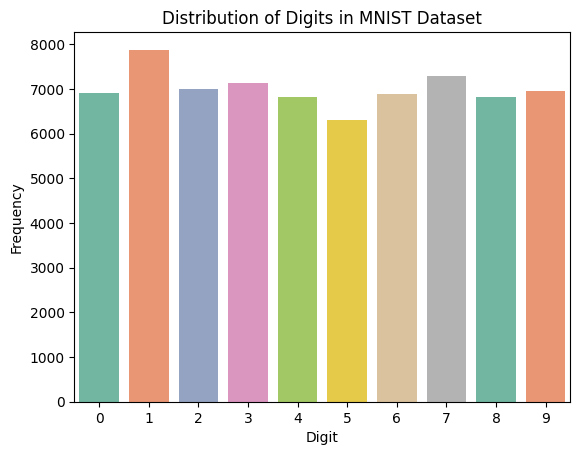

In [6]:
# Display & Visualise class distribution
sns.countplot(x=y, hue=y, palette="Set2", legend=False)
plt.title("Distribution of Digits in MNIST Dataset")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.show()

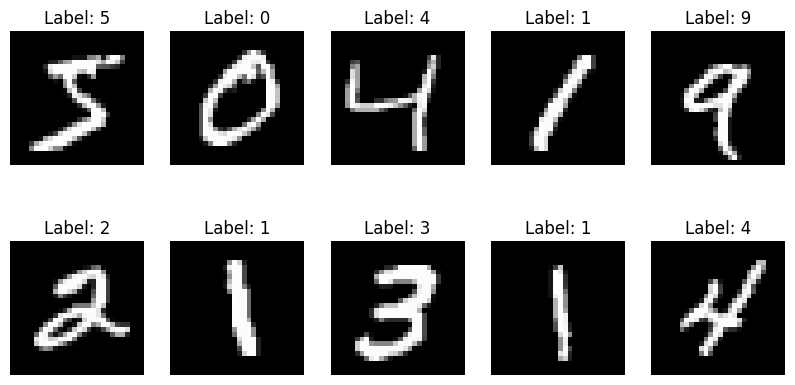

In [7]:
#Display Sample Handwritten Digits

# Ensure X is a NumPy array
X_array = np.array(X)
# Display some example images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_array[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis("off")
plt.show()

**DATA PREPARATION**

Standardization Method - k-NN, SVMs
Better for algorithms relying on distance between data point
When calculating Standard Deviation, you use the mean of pixel values, which is different for every image, which results in different SD values

In [8]:
scaler = StandardScaler()
X_prepared = scaler.fit_transform(X)

Normalization method - neural networks
Better for neural networks as negative vlues are not ideal (Esp using ReLU which ignores negative inputs, causing inefficiency)
Provides consistency

In [9]:
X_prepared = X / 255.0

In [9]:
# Spliting dataset into training (80) & testing (20) sets
# Explain why this split #TODO

X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (56000, 784)
Test data shape: (14000, 784)
Training labels shape: (56000,)
Test labels shape: (14000,)


**ALGORITHMS**

Algo 1 : SVM Support Vector Machine (Bernice Goo)

Finding best hyperparameters using Grid Search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'C': 10.0, 'kernel': 'poly'}
Training the best SVM model on full dataset...

SVM Model Evaluation:
Accuracy: 97.66%
Precision: 97.67%
Recall: 97.66%
F1-score: 97.66%
Training Time: 471.6343 seconds
Prediction Time: 106.2727 seconds
Model Complexity (Number of Support Vectors): 14785
Kernel Type: poly
C Value: 10.0

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.97      0.98      0.98      1380
           3       0.98      0.96      0.97      1433
           4       0.97      0.98      0.97      1295
           5       0.98      0.98      0.98      1273
           6       0.99      0.98      0.99      1396
           7       0.98      0.97      0.97      1503
           8       0.96      0.97   

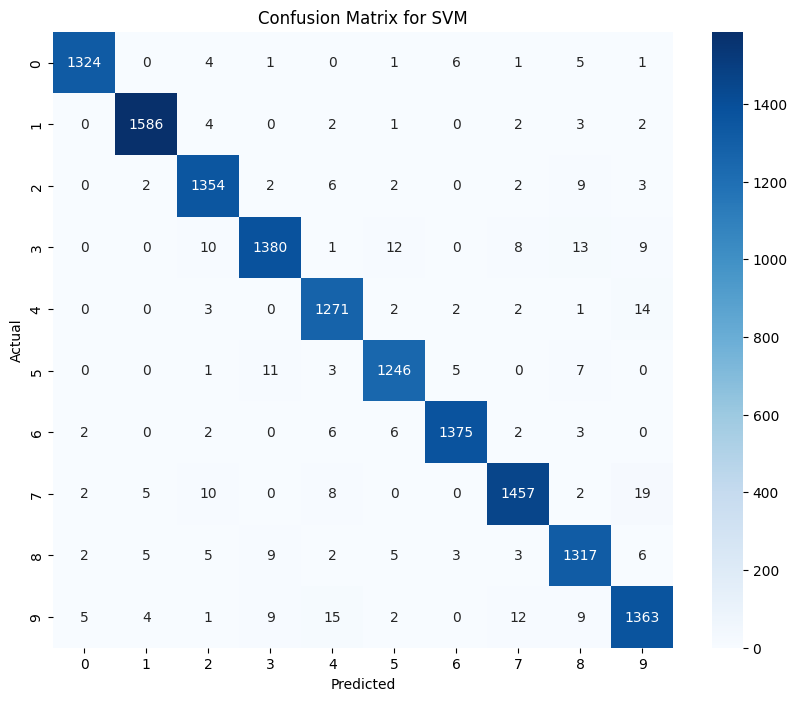

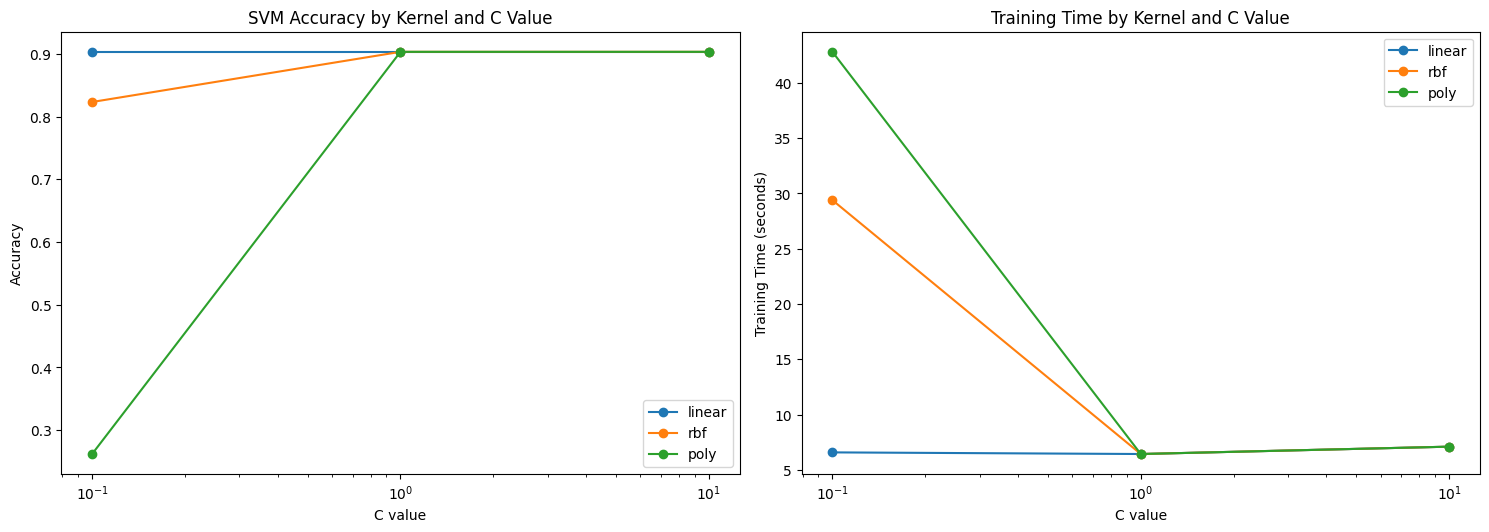

C:\Users\berni\AppData\Local\Temp\ipykernel_8712\4019809301.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Set3")
C:\Users\berni\AppData\Local\Temp\ipykernel_8712\4019809301.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Set3")


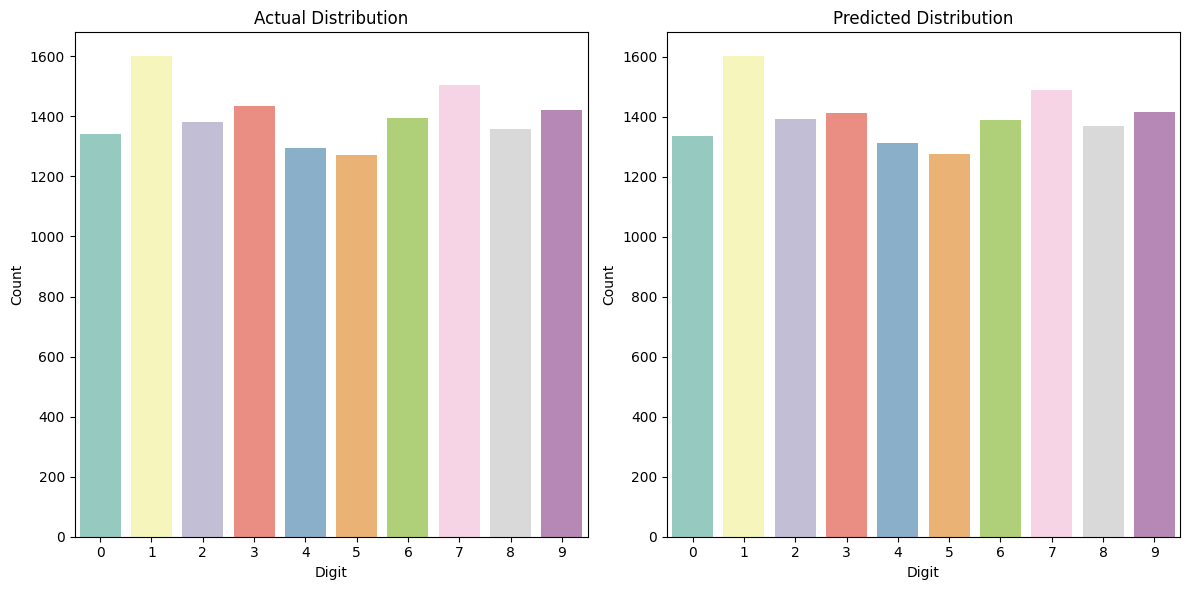

In [10]:
import time
from sklearn.svm import SVC

# Define parameters for SVM
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly']
}

# Take a subset for initial testing due to computational constraints
n_samples = 5000  # Adjust based on your computational resources
X_train_small = X_train[:n_samples]
y_train_small = y_train[:n_samples]

# Initialize SVM model
svm = SVC(random_state=42)

# Use GridSearchCV to find the best hyperparameters
print("Finding best hyperparameters using Grid Search...")
grid_search = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1, verbose=1)

# Start time for training grid search
start_time = time.time()
grid_search.fit(X_train_small, y_train_small)
grid_search_time = time.time() - start_time

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best SVM model on the full dataset
best_svm = SVC(C=best_params['C'], kernel=best_params['kernel'], random_state=42)

# Start time for training
print("Training the best SVM model on full dataset...")
start_time = time.time()
best_svm.fit(X_train, y_train)
training_time = time.time() - start_time

# Start time for prediction
start_time = time.time()
y_pred = best_svm.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1 = classification_rep["weighted avg"]["f1-score"]

# Model complexity is related to number of support vectors and kernel type
model_complexity = len(best_svm.support_vectors_)

# Print evaluation metrics
print("\nSVM Model Evaluation:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Support Vectors): {model_complexity}")
print(f"Kernel Type: {best_params['kernel']}")
print(f"C Value: {best_params['C']}")

# Display classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVM")
plt.show()

# Visualization of SVM performance by kernel and C value
results = []
for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        # Just extract the results from the grid search
        idx = list(grid_search.cv_results_['param_kernel']).index(kernel)
        idx = idx + list(grid_search.cv_results_['param_C'][idx:]).index(C)
        
        results.append({
            'kernel': kernel,
            'C': C,
            'accuracy': grid_search.cv_results_['mean_test_score'][idx],
            'training_time': grid_search.cv_results_['mean_fit_time'][idx]
        })

# Plot SVM performance comparison
plt.figure(figsize=(15, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
for kernel in param_grid['kernel']:
    kernel_results = [r for r in results if r['kernel'] == kernel]
    kernel_results.sort(key=lambda x: x['C'])
    plt.plot([r['C'] for r in kernel_results], 
             [r['accuracy'] for r in kernel_results], 
             'o-', label=kernel)

plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy by Kernel and C Value')
plt.legend()

# Training time plot
plt.subplot(2, 2, 2)
for kernel in param_grid['kernel']:
    kernel_results = [r for r in results if r['kernel'] == kernel]
    kernel_results.sort(key=lambda x: x['C'])
    plt.plot([r['C'] for r in kernel_results], 
             [r['training_time'] for r in kernel_results], 
             'o-', label=kernel)

plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time by Kernel and C Value')
plt.legend()

plt.tight_layout()
plt.show()

# Additional visualization: Class distribution in the predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_test, palette="Set3")
plt.title("Actual Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_pred, palette="Set3")
plt.title("Predicted Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Algo 2 : Random Forest (Bernice Chng)

Algo 3: K-Nearest Neighbors (KNN) (Carine)

Best Parameters: {'n_neighbors': 3}
KNN Model Accuracy: 97.13%
Precision: 97.14%
Recall: 97.13%
F1-score: 97.12%
Training Time: 82.4891 seconds
Prediction Time: 6.0986 seconds
Model Complexity (Number of Neighbors): 3
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1343
           1       0.96      0.99      0.98      1600
           2       0.97      0.97      0.97      1380
           3       0.97      0.96      0.97      1433
           4       0.97      0.96      0.97      1295
           5       0.98      0.97      0.97      1273
           6       0.98      0.99      0.99      1396
           7       0.97      0.98      0.97      1503
           8       0.99      0.94      0.96      1357
           9       0.96      0.95      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97   

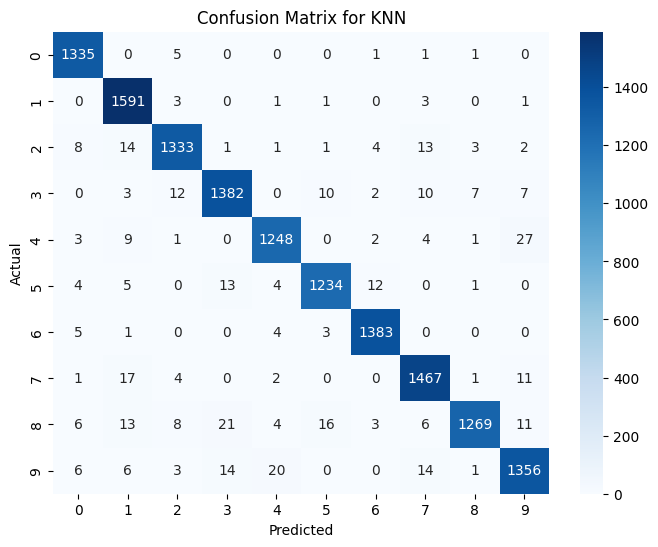

In [12]:
import time

# K-Nearest Neighbors (KNN) Model with Hyperparameter Tuning

# Define the parameter grid for KNN
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize KNN model
knn = KNeighborsClassifier()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Start time for training
start_time = time.time()
grid_search.fit(X_train, y_train)
training_time = time.time() - start_time

# Best hyperparameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best KNN model
best_knn = grid_search.best_estimator_

# Start time for prediction
start_time = time.time()
y_pred = best_knn.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

# Extracting precision, recall, and F1-score (averaged)
precision = classification_rep["weighted avg"]["precision"]
recall = classification_rep["weighted avg"]["recall"]
f1_score = classification_rep["weighted avg"]["f1-score"]

# Model complexity: Number of neighbors
model_complexity = best_params["n_neighbors"]

# Print evaluation metrics
print(f"KNN Model Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Training Time: {training_time:.4f} seconds")
print(f"Prediction Time: {prediction_time:.4f} seconds")
print(f"Model Complexity (Number of Neighbors): {model_complexity}")

# Display classification report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for KNN")
plt.show()



Algo 4 : Logistic Regression (Andrea)

Algo 5 : Decision Trees (Yin Er)

**COMPARISONS WITH ALGO**
- Accuracy
- Precision
- Recall
- F1-score
- Computation time
- Model complexity